# Clustering Abstract for 2000-2001

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.window import Window
from pyspark.sql import functions as F
from pyspark.sql.functions import expr   
from pyspark.sql.functions import udf

from pyspark.sql import SparkSession
from pyspark import SparkFiles
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import StopWordsRemover

import matplotlib.pyplot as plt

from pyspark.ml.feature import HashingTF, IDF, Tokenizer, VectorAssembler
from pyspark.sql.functions import col

from pyspark.ml.feature import Word2Vec

#create a Spark application
spark = SparkSession.builder.enableHiveSupport().appName('eda').getOrCreate()
sc = spark.sparkContext
#spark.debug.maxToStringFields=60

#from pyspark.conf import SparkConf
spark.conf.set("spark.sql.debug.maxToStringFields", 500)

spark.sparkContext.uiWebUrl

#print spark configuration settings
spark.sparkContext.getConf().getAll()

[('spark.stage.maxConsecutiveAttempts', '10'),
 ('spark.dynamicAllocation.minExecutors', '1'),
 ('spark.eventLog.enabled', 'true'),
 ('spark.dataproc.sql.joinConditionReorder.enabled', 'true'),
 ('spark.executor.memory', '5739m'),
 ('spark.dataproc.sql.local.rank.pushdown.enabled', 'true'),
 ('spark.eventLog.dir',
  'gs://dataproc-temp-us-central1-635155370842-uzamlpgc/ce784abe-d876-4af3-bf5e-a591f899969a/spark-job-history'),
 ('spark.yarn.unmanagedAM.enabled', 'true'),
 ('spark.sql.autoBroadcastJoinThreshold', '43m'),
 ('spark.ui.filters',
  'org.apache.hadoop.yarn.server.webproxy.amfilter.AmIpFilter'),
 ('spark.app.startTime', '1678151998474'),
 ('spark.metrics.namespace',
  'app_name:${spark.app.name}.app_id:${spark.app.id}'),
 ('spark.dataproc.sql.optimizer.leftsemijoin.conversion.enabled', 'true'),
 ('spark.hadoop.hive.execution.engine', 'mr'),
 ('spark.history.fs.logDirectory',
  'gs://dataproc-temp-us-central1-635155370842-uzamlpgc/ce784abe-d876-4af3-bf5e-a591f899969a/spark-job-

In [ ]:
# Writing to parquet; run the first two lines only once
#temp_df = spark.read.json("gs://msca-bdp-student-gcs/Group5_Final_Project/raw_data/dblp_v14.json").repartition(20)
#temp_df.write.parquet('gs://msca-bdp-student-gcs/Group5_Final_Project/raw_data/dhruv_par.parquet')

In [3]:
# read the parquet
df = spark.read.parquet('gs://msca-bdp-student-gcs/Group5_Final_Project/raw_data/dhruv_par.parquet')

In [4]:
df.count()

5259859

In [5]:
df_new = df.select(df.fos[0].getItem('name'), df.authors[0].getItem('name'), df.abstract, df.title, df.year)

df_new = df_new.withColumnRenamed("fos[0].name","category")\
    .withColumnRenamed("authors[0].name","author_name")

# dropping rows with na in any column
df_new = df_new.dropna()

In [6]:
df_new.count()

3586177

In [7]:

year_list = [2000,2001]
df_read = df_new.filter(df_new.year.isin(year_list)) #count = 2235775
df_read = df_read.dropna()



In [8]:
df_read.count()

117304

In [9]:
#removing rows where abstract is empty

df_read = df_read.filter("abstract != ''")

df_read = df_read.filter(trim(col("abstract")) != "null")

#remove all the abstracts which are duplicate
abstracts_to_remove = df_read.groupBy("abstract").count().orderBy(col("count")).filter(col("count")>1)
abstracts_remove_list = abstracts_to_remove.rdd.map(lambda x: x[0]).collect()
df_read = df_read.filter(~df_read.abstract.isin(abstracts_remove_list))

#trim whitespace
df_read = df_read.withColumn("abstract", trim(df.abstract))
#remove redundant space between words
df_read = df_read.withColumn("abstract", regexp_replace("abstract", "\s+", " "))
#remove punctuation marks
df_read = df_read.withColumn("abstract", regexp_replace("abstract", "[^\\w\\s]+", ""))


In [9]:
df_read.count()

96765

### Tokenizer

In [10]:
tokenizer = Tokenizer(inputCol="abstract", outputCol="words")
df_read = tokenizer.transform(df_read)
#remove stop words
remover = StopWordsRemover(inputCol="words", outputCol="filtered")
df_read = remover.transform(df_read)

#drop the redundant source column
df_read= df_read.drop("words")

In [11]:
df_read.show()

+--------------------+--------------------+--------------------+--------------------+----+--------------------+
|            category|         author_name|            abstract|               title|year|            filtered|
+--------------------+--------------------+--------------------+--------------------+----+--------------------+
|   Computer security|        Moses Liskov|We study the twop...|Mutually Independ...|2001|[study, twoparty,...|
|             Plucker|     J. K. Johnstone|We develop an eff...|A Parametric Solu...|2001|[develop, efficie...|
|            Web page|  Sucheta Nadimpalli|With increasing b...|Techniques for Ac...|2000|[increasing, band...|
|      Tensor product|             N. Alon|Let C denote the ...|Unextendible prod...|2001|[let, c, denote, ...|
|Pipeline burst cache|           S.-M. Kim|Prefetching bring...|A Parallel Proces...|2000|[prefetching, bri...|
| Electronic business|   Nadja Linketscher|Abstract Electron...|Trust Issues and ...|2001|[abstract, ele

### Vectorizing the abstract

In [11]:
vec_size = 50
word2Vec = Word2Vec(vectorSize=vec_size, minCount=0, inputCol="filtered", outputCol="wordVectors")

In [12]:
w2VM = word2Vec.fit(df_read)
nlpdf = w2VM.transform(df_read)
nlpdf.select(col("wordVectors")).show()

23/03/07 02:21:35 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/03/07 02:21:35 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


+--------------------+
|         wordVectors|
+--------------------+
|[-0.0162625890351...|
|[-0.0962897918562...|
|[-0.0294463464294...|
|[-0.0193693689326...|
|[-0.0149125148941...|
|[0.11869647781644...|
|[-0.0214044315344...|
|[0.00983655285915...|
|[-0.0644785442855...|
|[0.10926261478258...|
|[0.04047311724138...|
|[0.04589565980422...|
|[0.03540819037252...|
|[-0.0461070219155...|
|[-0.0815273079217...|
|[0.03221604400979...|
|[-0.1151989946406...|
|[-0.3318577905734...|
|[0.05301483775422...|
|[0.02543425411048...|
+--------------------+
only showing top 20 rows



#### Splitting the wordvector

In [13]:
from pyspark.ml.functions import vector_to_array
nlpdf_new = nlpdf.withColumn("vec", vector_to_array("wordVectors")).select(["category", "author_name", "year"] + [col("vec")[i] for i in range(vec_size)])

### K-means clustering

In [14]:
nlpdf_new.printSchema()

root
 |-- category: string (nullable = true)
 |-- author_name: string (nullable = true)
 |-- year: long (nullable = true)
 |-- vec[0]: double (nullable = true)
 |-- vec[1]: double (nullable = true)
 |-- vec[2]: double (nullable = true)
 |-- vec[3]: double (nullable = true)
 |-- vec[4]: double (nullable = true)
 |-- vec[5]: double (nullable = true)
 |-- vec[6]: double (nullable = true)
 |-- vec[7]: double (nullable = true)
 |-- vec[8]: double (nullable = true)
 |-- vec[9]: double (nullable = true)
 |-- vec[10]: double (nullable = true)
 |-- vec[11]: double (nullable = true)
 |-- vec[12]: double (nullable = true)
 |-- vec[13]: double (nullable = true)
 |-- vec[14]: double (nullable = true)
 |-- vec[15]: double (nullable = true)
 |-- vec[16]: double (nullable = true)
 |-- vec[17]: double (nullable = true)
 |-- vec[18]: double (nullable = true)
 |-- vec[19]: double (nullable = true)
 |-- vec[20]: double (nullable = true)
 |-- vec[21]: double (nullable = true)
 |-- vec[22]: double (nullable

In [15]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, VectorAssembler

column_names = []
for i in range (vec_size):
    col_name = "vec[{}]".format(i)
    column_names.append(col_name)

vecAssembler = VectorAssembler(inputCols = column_names, outputCol="features")
new_df = vecAssembler.transform(nlpdf_new)

#### Finding adequate number of clusters

In [16]:

silhouette_scores=[]
evaluator = ClusteringEvaluator(featuresCol='features', \
metricName='silhouette', distanceMeasure='squaredEuclidean')

for K in range(2,11):

    KMeans_=KMeans(featuresCol='features', k=K)

    KMeans_fit=KMeans_.fit(new_df)

    KMeans_transform=KMeans_fit.transform(new_df) 

    evaluation_score=evaluator.evaluate(KMeans_transform)

    silhouette_scores.append(evaluation_score)
    


Text(0, 0.5, 'Silhouette Score')

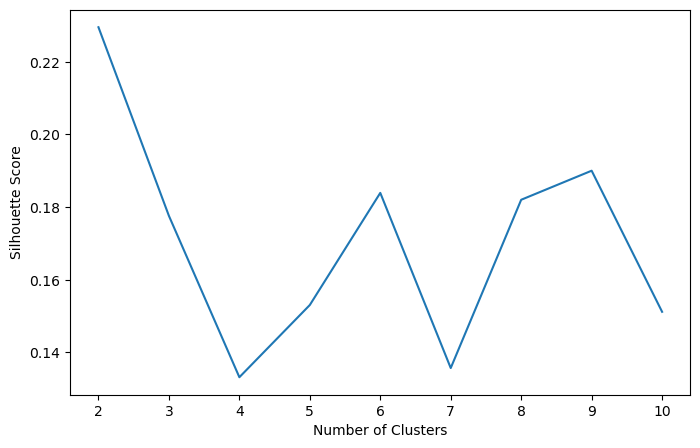

In [17]:
fig, ax = plt.subplots(1,1, figsize =(8,5))
ax.plot(range(2,11),silhouette_scores)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Silhouette Score')

#### Clustering after finding the adequate number of clusters

In [18]:
from pyspark.ml.clustering import KMeans
num_clusters = 7
kmeans = KMeans(k=num_clusters, seed=1)
model = kmeans.fit(new_df.select('features'))
transformed = model.transform(new_df)
transformed.select(col("prediction")).show(10)

+----------+
|prediction|
+----------+
|         3|
|         4|
|         5|
|         6|
|         5|
|         1|
|         1|
|         1|
|         4|
|         5|
+----------+
only showing top 10 rows



### Now we just have to group by category and cluster prediction. 


In [19]:
transformed.printSchema()
df_agg = transformed.groupBy("category", "prediction").count()
df_agg.show(10)

root
 |-- category: string (nullable = true)
 |-- author_name: string (nullable = true)
 |-- year: long (nullable = true)
 |-- vec[0]: double (nullable = true)
 |-- vec[1]: double (nullable = true)
 |-- vec[2]: double (nullable = true)
 |-- vec[3]: double (nullable = true)
 |-- vec[4]: double (nullable = true)
 |-- vec[5]: double (nullable = true)
 |-- vec[6]: double (nullable = true)
 |-- vec[7]: double (nullable = true)
 |-- vec[8]: double (nullable = true)
 |-- vec[9]: double (nullable = true)
 |-- vec[10]: double (nullable = true)
 |-- vec[11]: double (nullable = true)
 |-- vec[12]: double (nullable = true)
 |-- vec[13]: double (nullable = true)
 |-- vec[14]: double (nullable = true)
 |-- vec[15]: double (nullable = true)
 |-- vec[16]: double (nullable = true)
 |-- vec[17]: double (nullable = true)
 |-- vec[18]: double (nullable = true)
 |-- vec[19]: double (nullable = true)
 |-- vec[20]: double (nullable = true)
 |-- vec[21]: double (nullable = true)
 |-- vec[22]: double (nullable

+--------------------+----------+-----+
|            category|prediction|count|
+--------------------+----------+-----+
|Automatic image a...|         2|   11|
|           Weighting|         4|   18|
|Hash-based messag...|         0|    3|
|   Decision analysis|         1|   49|
|    Computer science|         0|  319|
|Maintenance strategy|         1|    2|
|           Ask price|         1|    9|
|Intelligent envir...|         1|    3|
|      Capitalization|         1|    2|
|    State government|         1|    1|
+--------------------+----------+-----+
only showing top 10 rows



In [20]:
from pyspark.sql.window import Window
from pyspark.sql.functions import rank, col

window = Window.partitionBy(df_agg['prediction']).orderBy(df_agg['count'].desc())
df_short = df_agg.select('*', rank().over(window).alias('rank')).filter(col('rank') <= 5) 

In [21]:
df_short.show(100)

+--------------------+----------+-----+----+
|            category|prediction|count|rank|
+--------------------+----------+-----+----+
|  Information system|         1| 1268|   1|
|      World Wide Web|         1|  954|   2|
|    Computer science|         1|  889|   3|
|         Data mining|         1|  581|   4|
|        Data science|         1|  370|   5|
|Discrete mathematics|         6| 1957|   1|
|             Integer|         6|  317|   2|
|        Graph theory|         6|  217|   3|
|       Combinatorics|         6|  144|   4|
|Mathematical opti...|         6|  121|   5|
|         Data mining|         3| 1084|   1|
|    Computer science|         3| 1071|   2|
|Programming language|         3|  490|   3|
|Mathematical opti...|         3|  415|   4|
|  Information system|         3|  250|   5|
|    Computer science|         5|  524|   1|
|    Mobile computing|         5|  249|   2|
|    Wireless network|         5|  182|   3|
|Wavelength-divisi...|         5|  150|   4|
|Source-sp

In [22]:
df_short.write.option("header",True).csv("gs://msca-bdp-student-gcs/Group5_Final_Project/raw_data/dhruv_res_prelim/2000_new_March6.csv")

We have visualized the above table in clustering_res_plot.ipynb. We can see that in this table, the clusters are very standard. Discrete mathematics is with Graph Theory and Combinatorics. Mobile computing is with wireless network. Thus we can conclude that in 2000, there were not a lot of interdisciplinary interactions. We will see how things will change in 2010.ipynb and 2018.ipynb

In [ ]:
#Do not run these
#df_2000 = spark.read.csv("gs://msca-bdp-student-gcs/Group5_Final_Project/raw_data/dhruv_res_prelim/2000_new_March6.csv", inferSchema=True, header=True)
#df_2000.repartition(1).write.option("header",True).csv("gs://msca-bdp-student-gcs/Group5_Final_Project/raw_data/dhruv_res_prelim/2000_march6_repartitioned.csv")